<a href = "https://www.pieriantraining.com"><img src="../PT Centered Purple.png"> </a>

<em style="text-align:center">Copyrighted by Pierian Training</em>

# Automatic Blog Post creator

In this project we will build a blog poster that writes a blog post given something to talk about or discuss.
Additionally, a chariming cover photo will be created!

## Imports

In [156]:
import random
import string
from pathlib import Path
import os
import requests
import shutil

from git import Repo
from bs4 import BeautifulSoup as Soup
import openai
from PIL import Image

### Paths:

In [157]:
#PATH_TO_BLOG_REPO = Path("/Users/marci/GIT/OpenAI-API-Python-Course/04-Auto-Blog-Post/b4shy.github.io/.git/")
PATH_TO_BLOG_REPO = Path('C/path/to/.git')
PATH_TO_BLOG = PATH_TO_BLOG_REPO.parent
PATH_TO_CONTENT = PATH_TO_BLOG/"content"
PATH_TO_CONTENT.mkdir(exist_ok=True, parents=True)

In [158]:
PATH_TO_BLOG

PosixPath('/Users/marci/GIT/OpenAI-API-Python-Course/04-Auto-Blog-Post/b4shy.github.io')

## Github Pages

1. Create a new public repository on github named **username.github.io**, where username is github username.
2. Clone the repository
3. Create a new file called **index.html**
4. Add some content to **index.html**
5. Push your changes
6. Goto https://username.github.io

## Automatic updates

Manually adding, commiting and pushing is tedious. Thus we are going to implement functionality that handles everything for us.
Before using openai to generate content for us, we evaluate our code using random strings!

In [159]:
def random_string(length):
    letters = string.ascii_lowercase + "\n"
    
    return ''.join(random.choice(letters) for i in range(length))

random_string(10)

'efnhvqxlfo'

In [160]:
def update_blog(commit_message="Updated blog"):
    repo = Repo(PATH_TO_BLOG_REPO)
    repo.git.add(all=True)
    repo.index.commit(commit_message)
    origin = repo.remote(name='origin')
    origin.push()


Let's create a random text and push it to our blog!

In [142]:
random_blogpost = random_string(1000)

In [ ]:
with open(PATH_TO_BLOG/"index.html", "w") as f:
    f.write(random_blogpost)

In [ ]:
update_blog()

Now, let's check if our blog got updated! Note that it might take a minute or two.

One problem remains: We always overwrite the starting page!
It would be much better to create a new html file and create a link to this file on the homepage. 
Ideally, the routine would automatically assign a file name and make sure that nothing is overwritten!

In [182]:
def create_new_blog(title, content, cover_image=Path("../PT Centered Purple.png")):
    
    cover_image = Path(cover_image)
    
    files =len(list(PATH_TO_CONTENT.glob("*.html")))
    new_title = f"{files+1}.html"
    path_to_new_content = PATH_TO_CONTENT/new_title
    
    shutil.copy(cover_image, PATH_TO_CONTENT)
    if not os.path.exists(path_to_new_content):
        with open(path_to_new_content, "w") as f:
            f.write("<!DOCTYPE html>\n")
            f.write("<html>\n")
            f.write("<head>\n")
            f.write(f"<title> {title} </title>\n")
            f.write("</head>\n")
            
            f.write("<body>\n")
            f.write(f"<img src='{cover_image.name}' alt='Cover Image'> <br />\n")
            f.write(f"<h1> {title} </h1>")
            f.write(content.replace("\n", "<br />\n"))
            f.write("</body>\n")
            f.write("</html>\n")
            print("Blog created")
            return path_to_new_content
    else:
        raise FileExistsError("File already exist! Abort")

In [175]:
path_to_new_content = create_new_blog("Title", random_string(5000))

Blog created


Now all we have to do in order to access our new blog is to add the link to index.html.
Let's manually overwrite index.html with the following code.

After that we can use beautifulsoup to automatically add the link to index.html

In [176]:
with open(PATH_TO_BLOG/"index.html") as index:
    soup = Soup(index.read())
str(soup)

'<!DOCTYPE html>\n\n<html>\n<head>\n<title>My Blog</title>\n</head>\n<body>\n<h1>My Blog</h1>\n<a href="index.html">Home</a>\n</body>\n</html>'

In [177]:
def check_for_duplicate_links(path_to_new_content, links):
    urls = [str(link.get("href")) for link in links]
    content_path = str(Path(*path_to_new_content.parts[-2:]))
    return content_path in urls
    

In [178]:
def write_to_index(path_to_new_content):
    with open(PATH_TO_BLOG/"index.html") as index:
        soup = Soup(index.read())

    links = soup.find_all("a")
    last_link = links[-1]
    
    if check_for_duplicate_links(path_to_new_content, links):
        raise ValueError("Link does already exist!")
        
    link_to_new_blog = soup.new_tag("a", href=Path(*path_to_new_content.parts[-2:]))
    link_to_new_blog.string = path_to_new_content.name.split(".")[0]
    last_link.insert_after(link_to_new_blog)
    
    with open(PATH_TO_BLOG/"index.html", "w") as f:
        f.write(str(soup.prettify(formatter='html')))

In [179]:
write_to_index(path_to_new_content)

Last but not least we can push the new blogpost to the repostory!
Again it might take one or two minutes until you can see your changes

In [180]:
update_blog()

## OpenAI API

Remember to use the notebook as shown, you must set your OpenAI API Key as an environment variable. Obviously, there are many ways you could provide your API Key to the Python code, input() or even hard-coded, but those are typically not recommended for safety reasons. Having it as an environment variable let's the key live on the computer, but not actually be present in the code.

### Set-up Open AI API Key

We'll only need to do this once per computer

In [16]:
# Uncomment below and swap in your key to place your environment key using Python
# Then you can delete the key string and the code cell below will still work!
# os.environ["OPENAI_API_KEY"] = "Your key goes here!

In [17]:
openai.api_key = os.getenv("OPENAI_API_KEY")

### Tell GPT to generate a blogpost
We will tell GPT to generate a blogpost about a topic of interest.

### Prompt Tuning:
To get the best out of GPT, we should inform it about our biography and give some hints about the blogpost. We directly assign a nice and catching title

In [30]:
def create_prompt(title):
    prompt = """Jose's Website
 
 Biography
 I am a Python instructor teaching people machine learning!


 Blog

 Jan 31, 2023
 Title: Why AI will never replace the radiologist
 tags: tech, machine-learning, radiology
 Summary:  I talk about the cons of machine learning in radiology. I explain why I think that AI will never replace the radiologist.
 Full text: """.format(title)
    return prompt

In [ ]:
title = "Why AI will never replace the radiologist"
print(create_prompt(title))

### OpenAI API Call
Let's use text-davinci-003 to create the blog post!

In [189]:
response = openai.Completion.create(engine="text-davinci-003",
                                            prompt=create_prompt(title),
                                            max_tokens=512,  # we increased the tokens to get a longer blog post
                                            temperature=0.7)

In [190]:
blog_content = response["choices"][0]["text"]

In [191]:
print(blog_content)



The promise of artificial intelligence (AI) to revolutionize medical imaging is undeniable. The potential for AI to automatically detect and diagnose medical conditions from X-ray and CT scans is a huge step forward in the field of radiology. However, while AI may be able to detect and diagnose certain conditions, it is unlikely that it will ever replace the radiologist.

The reason why AI will never replace the radiologist is because radiology is a complex field that requires a deep understanding of the anatomy, pathology, and physiology of the human body. AI algorithms can only detect and diagnose certain conditions, but they do not possess the same depth of knowledge and experience as a radiologist. A radiologist is able to look at a scan and come to a diagnosis based on their years of experience and expertise, something AI cannot do.

Moreover, AI-based diagnosis is very much dependent on the quality of the data used to train the algorithm. A radiologist is able to detect subtle 

### Dalle2 prompt
We will now create the prompt which we pass to dalle2 

In [192]:
def dalle2_prompt(title):
    prompt = f"Pixel art showing '{title}'."
    return prompt

In [193]:
image_prompt = dalle2_prompt(title)
image_prompt

"Pixel art showing 'Why AI will soon replace the radiologist'."

In [194]:
response = openai.Image.create(
  prompt=image_prompt,
  n=1,
  size="1024x1024"
)


In [195]:
image_url = response['data'][0]['url']


In [196]:
def save_image(image_url, file_name):
    image_res = requests.get(image_url, stream = True)
    
    if image_res.status_code == 200:
        with open(file_name,'wb') as f:
            shutil.copyfileobj(image_res.raw, f)
    else:
        print("Error downloading image!")
    return image_res.status_code


In [204]:
save_path = "title2.png"

In [205]:
save_image(image_url, save_path)

200

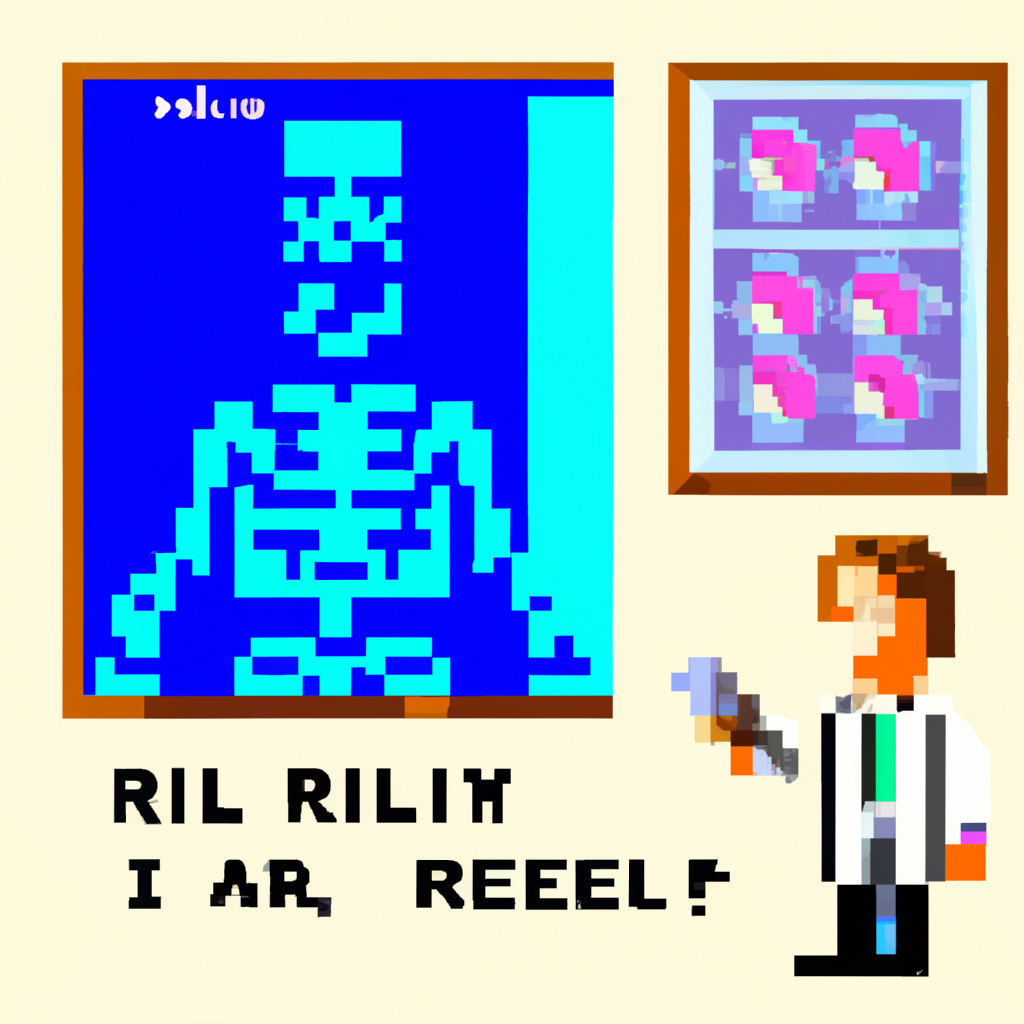

In [206]:
Image.open(save_path)

In [207]:
title

'Why AI will soon replace the radiologist'

In [208]:
blog_content

'\n\nThe promise of artificial intelligence (AI) to revolutionize medical imaging is undeniable. The potential for AI to automatically detect and diagnose medical conditions from X-ray and CT scans is a huge step forward in the field of radiology. However, while AI may be able to detect and diagnose certain conditions, it is unlikely that it will ever replace the radiologist.\n\nThe reason why AI will never replace the radiologist is because radiology is a complex field that requires a deep understanding of the anatomy, pathology, and physiology of the human body. AI algorithms can only detect and diagnose certain conditions, but they do not possess the same depth of knowledge and experience as a radiologist. A radiologist is able to look at a scan and come to a diagnosis based on their years of experience and expertise, something AI cannot do.\n\nMoreover, AI-based diagnosis is very much dependent on the quality of the data used to train the algorithm. A radiologist is able to detect 

In [209]:
path_to_new_content = create_new_blog(title, blog_content, save_path)

Blog created


In [202]:
write_to_index(path_to_new_content)

In [203]:
update_blog()